# **Titanic Survival Prediction**
### **Introduction**
The sinking of the Titanic remains one of history's most tragic maritime disasters. On April 15, 1912, the "unsinkable" RMS Titanic struck an iceberg and sank, resulting in the deaths of 1,502 out of 2,224 passengers and crew. The limited number of lifeboats meant survival often depended on socioeconomic status, gender, age, and chance.

This analysis investigates which factors most influenced survival and builds a predictive model to answer:
* "What types of passengers were most likely to survive the Titanic disaster?"

### **Part 1: Setup & Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

### **Part 2: Data Loading & Feature Engineering**

In [2]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

print("Training Data")
print(f"Shape: {train.shape}")
print(f"Columns: {train.columns.tolist()}")
print("\nTest Data")
print(f"Shape: {test.shape}")
print(f"Columns: {test.columns.tolist()}")

print("\nMissing Values")
print("Training Set:")
print(train.isnull().sum())
print("\nTest Set:")
print(test.isnull().sum())

Training Data
Shape: (891, 12)
Columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Test Data
Shape: (418, 11)
Columns: ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Missing Values
Training Set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Set:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### **Handling Missing Values**

In [3]:
print("Training Data Columns:")
print(train.columns.tolist())

print("\nTest Data Columns:")
print(test.columns.tolist())

Training Data Columns:
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Test Data Columns:
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


#### **1. Age**
* **Approach:** Impute with median age grouped by Title (Mr, Mrs, Miss, etc.) since different titles have different typical ages.

In [4]:
def extract_title(name):
    return name.split(', ')[1].split('.')[0].strip()

for df in [train, test]:
    df['Title'] = df['Name'].apply(extract_title)

print("Unique Titles:")
print(pd.concat([train['Title'], test['Title']]).unique())

Unique Titles:
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [5]:
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Mlle': 'Miss',       # french "Mademoiselle" = Miss
    'Ms': 'Miss',
    'Mme': 'Mrs',         # french "Madame" = Mrs
    'Dr': 'Rare',
    'Rev': 'Rare',
    'Col': 'Rare',
    'Major': 'Rare',
    'Lady': 'Rare',
    'Sir': 'Rare',
    'Don': 'Rare',
    'Countess': 'Rare',
    'Jonkheer': 'Rare',
    'Dona': 'Rare',       # spanish honorific
    'Capt': 'Rare'        # captain
}

for df in [train, test]:
    df['Title'] = df['Title'].map(title_mapping)

print("\nTitle Counts (After Consolidation):")
print(train['Title'].value_counts())


Title Counts (After Consolidation):
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       22
Name: count, dtype: int64


In [6]:
title_age_median = train.groupby('Title')['Age'].median()

for df in [train, test]:
    df['Age'] = df.apply(
        lambda row: title_age_median[row['Title']] if pd.isnull(row['Age']) else row['Age'],
        axis=1
    )

#### **2. Cabin**
* **Approach:** Drop the original cabin column as it has too many missing values, and create a new binary feature HasCabin (1 if cabin is known, 0 if missing).

In [7]:
for df in [train, test]:
    df['Deck'] = df['Cabin'].str[0].fillna('Unknown')
    df['HasCabin'] = df['Cabin'].notna().astype(int)
    
    df.drop('Cabin', axis=1, inplace=True)

print("Training missing after drop:\n", train.isnull().sum())
print("\nTest missing after drop:\n", test.isnull().sum())

Training missing after drop:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
Title          1
Deck           0
HasCabin       0
dtype: int64

Test missing after drop:
 PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Embarked       0
Title          0
Deck           0
HasCabin       0
dtype: int64


#### **3. Embarked**
* **Approach:** Fill with most frequent value as there are only 2 missing values.

In [8]:
train['Embarked'].fillna('S', inplace=True)

#### **4. Fare**
* **Approach:** Fill with median fare of the passenger class. The higher the class, the more expensive the fare.

In [9]:
class_fare_median = train.groupby('Pclass')['Fare'].median()

test['Fare'] = test.apply(
    lambda row: class_fare_median[row['Pclass']] if pd.isnull(row['Fare']) else row['Fare'],
    axis=1
)

#### **Missing Value Check**

In [10]:
print("\nMissing Values After Handling")
print("Training Set:")
print(train.isnull().sum())
print("\nTest Set:")
print(test.isnull().sum())


Missing Values After Handling
Training Set:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          1
Deck           0
HasCabin       0
dtype: int64

Test Set:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Deck           0
HasCabin       0
dtype: int64


*There are still 2 missing values in 'Embarked' and 1 in 'Title' in the training set.*

#### **5. Handling Embarked in Training Set**
* **Approach:** Fill with mode since it's categorical.

In [11]:
most_common_embarked = train['Embarked'].mode()[0]  # Returns 'S' (Southampton)

train['Embarked'].fillna(most_common_embarked, inplace=True)

print(f"Filled {train['Embarked'].isnull().sum()} missing 'Embarked' values with '{most_common_embarked}'")

Filled 0 missing 'Embarked' values with 'S'


#### **6. Handling Title in Training Set**
* **Approach:** Extract from name as it's most likely due to an unusual name format.

In [12]:
missing_title_row = train[train['Title'].isnull()] # check which row has missing title

if not missing_title_row.empty: # extract title manually
    print("Row with missing Title:")
    print(missing_title_row[['PassengerId', 'Name']])
    
    name = missing_title_row['Name'].values[0]
    extracted_title = name.split(', ')[1].split('.')[0].strip()
    
    train.loc[train['Title'].isnull(), 'Title'] = extracted_title
    print(f"Filled missing Title with '{extracted_title}'")

print("\nRemaining missing Titles:", train['Title'].isnull().sum())

Row with missing Title:
     PassengerId                                               Name
759          760  Rothes, the Countess. of (Lucy Noel Martha Dye...
Filled missing Title with 'the Countess'

Remaining missing Titles: 0


#### **Final Missing Value Check**

In [13]:
print("Final Missing Values")
print("Training Set:")
print(train.isnull().sum())

print("\nTest Set:")
print(test.isnull().sum())

Final Missing Values
Training Set:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Deck           0
HasCabin       0
dtype: int64

Test Set:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
Deck           0
HasCabin       0
dtype: int64


*Dataset is now ready for analysis.*

### **Part 3: Exploratory Data Analysis**

#### **3.1 Target Variable Distribution**

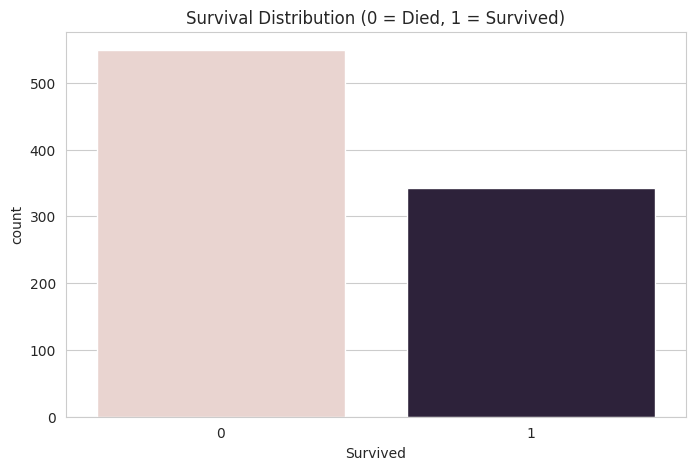

Overall Survival Rate: 38.38%


In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(
    x='Survived', 
    data=train, 
    palette=sns.cubehelix_palette(n_colors=2)  # Cubehelix with 2 colors
)
plt.title('Survival Distribution (0 = Died, 1 = Survived)')
plt.show()

survival_rate = train['Survived'].mean()
print(f"Overall Survival Rate: {survival_rate:.2%}")

#### **3.2 Key Feature Analysis**

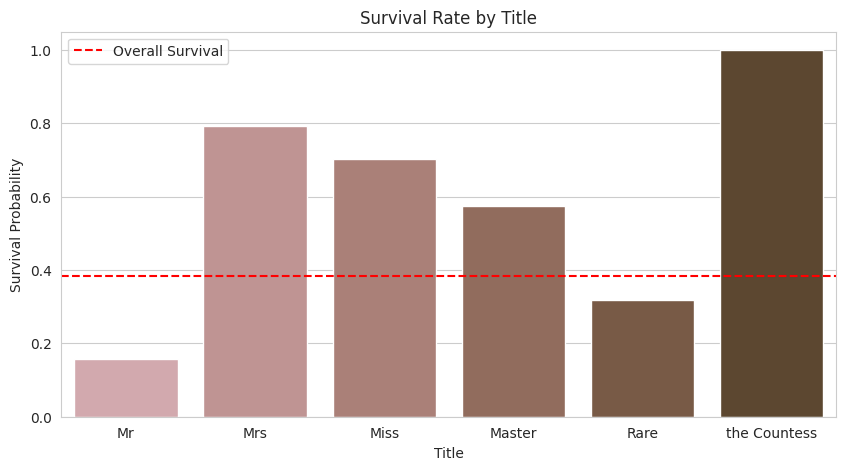

Title
Master          0.575000
Miss            0.702703
Mr              0.156673
Mrs             0.793651
Rare            0.318182
the Countess    1.000000
Name: Survived, dtype: float64


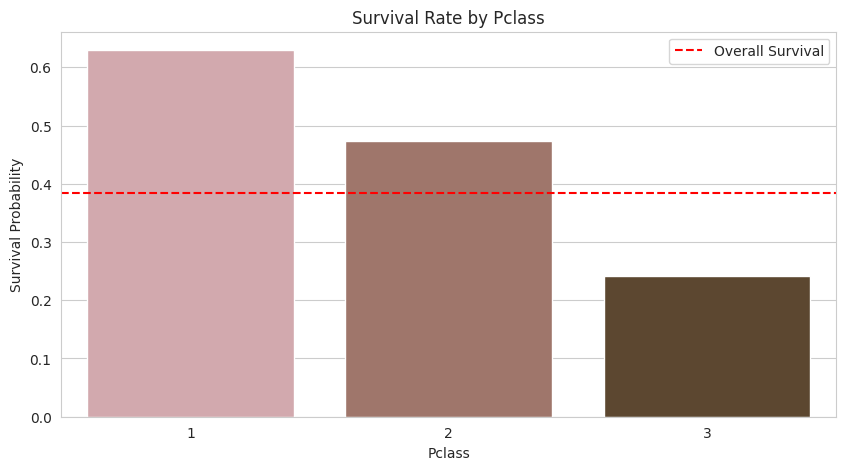

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


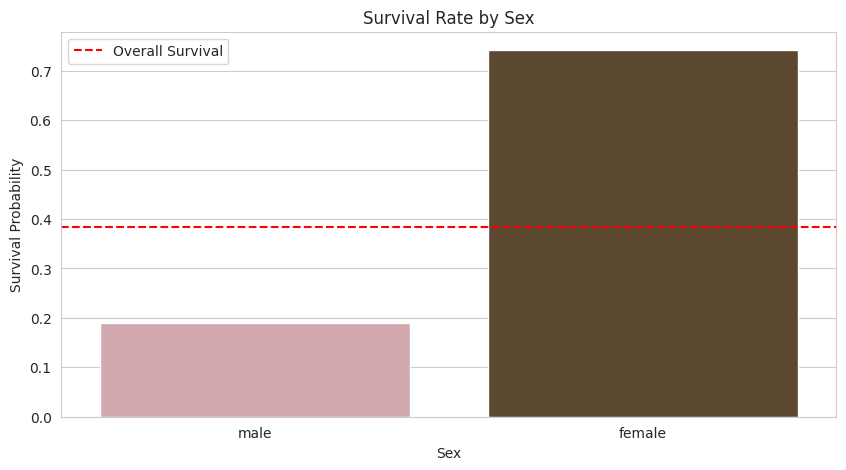

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


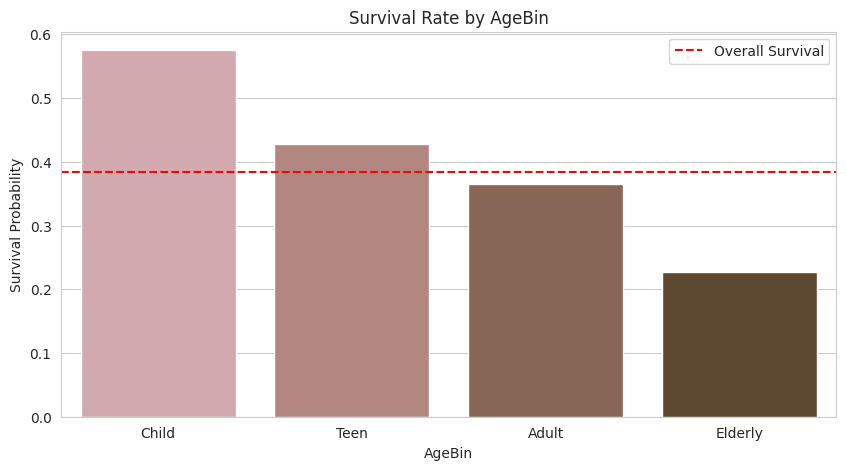

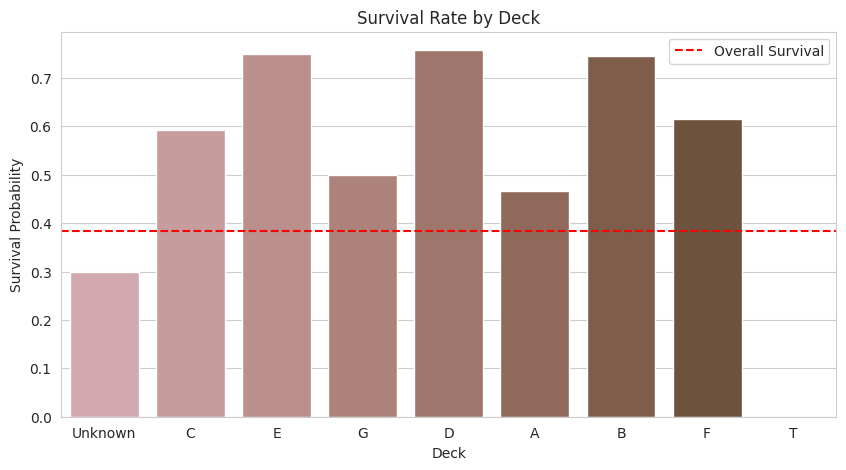

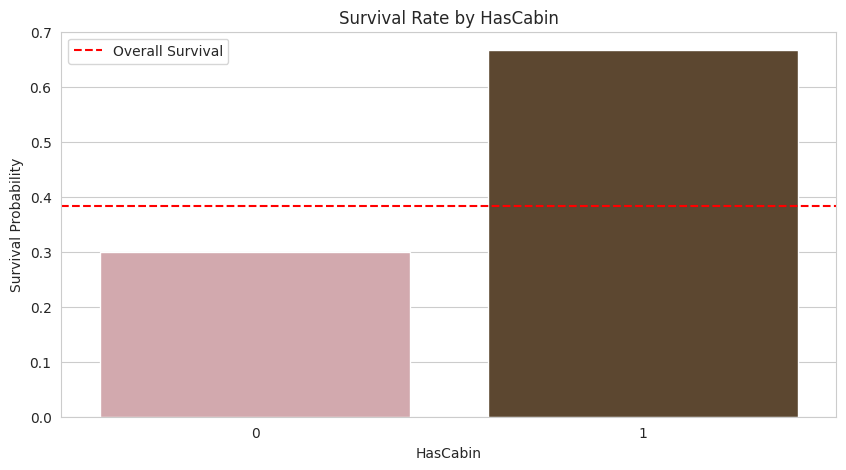

In [15]:
def plot_survival(feature, df=train):
    plt.figure(figsize=(10, 5))
    # Get cubehelix colors based on number of unique values in the feature
    n_colors = len(df[feature].unique())
    palette = sns.cubehelix_palette(n_colors=n_colors, start=1.5, rot=-0.3, dark=0.3, light=0.7)
    
    sns.barplot(
        x=feature, 
        y='Survived', 
        data=df, 
        ci=None,
        palette=palette  # Apply cubehelix palette here
    )
    plt.title(f'Survival Rate by {feature}')
    plt.ylabel('Survival Probability')
    plt.axhline(survival_rate, color='red', linestyle='--', label='Overall Survival')
    plt.legend()
    plt.show()

# Calculate overall survival rate first
survival_rate = train['Survived'].mean()

plot_survival('Title')
print(train.groupby('Title')['Survived'].mean())

# Analyze Pclass
plot_survival('Pclass')
print(train.groupby('Pclass')['Survived'].mean())

# Analyze Sex
plot_survival('Sex')
print(train.groupby('Sex')['Survived'].mean())

# Analyze Age (binned)
train['AgeBin'] = pd.cut(train['Age'], bins=[0, 12, 18, 60, 100], labels=['Child', 'Teen', 'Adult', 'Elderly'])
plot_survival('AgeBin')

plot_survival('Deck')
plot_survival('HasCabin')

#### **3.3 Family Feature Engineering**

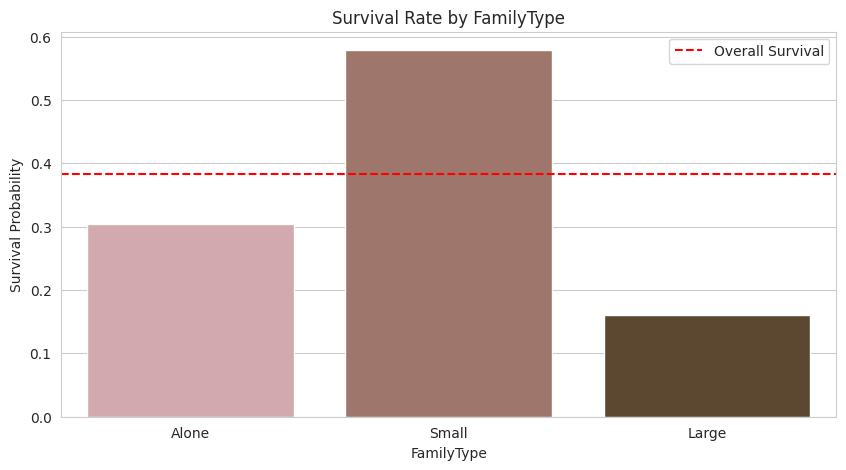

In [16]:
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=False)
    df['FamilyType'] = pd.cut(df['FamilySize'], 
                             bins=[0, 1, 4, 20],
                             labels=['Alone', 'Small', 'Large'])

plot_survival('FamilyType')

*Small families (2-4) often had better survival rates than solo travelers or large groups.*

### **Part 4: Model Training & Evaluation**

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       105
           1       0.78      0.78      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.82      0.82      0.82       179



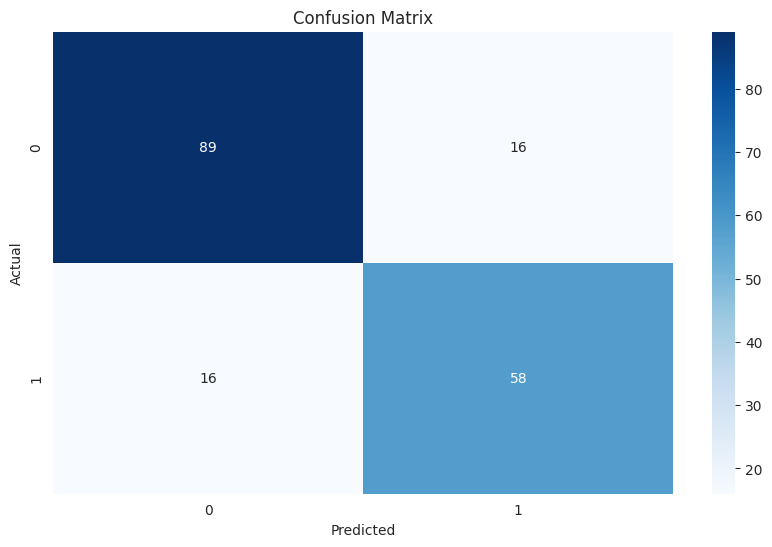

In [17]:
features = ['Pclass', 'Sex', 'Age', 'Title', 'Deck', 'HasCabin', 'FamilySize', 'IsAlone']
X = train[features]
y = train['Survived']

X = pd.get_dummies(X, columns=['Sex', 'Title', 'Deck'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# train
model = RandomForestClassifier()
model.fit(X_train, y_train)

# eval
preds = model.predict(X_val)
print(f"Accuracy: {accuracy_score(y_val, preds):.2f}")
print("\nClassification Report:")
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Part 5: Modeling Pipeline**

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

X_train = train.drop(['Survived', 'PassengerId', 'Name'], axis=1, errors='ignore')
y_train = train['Survived']
X_test = test.drop(['PassengerId', 'Name'], axis=1, errors='ignore')

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'AgeBin', 'IsAlone', 'FamilyType', 'Deck']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

test_pred = pipeline.predict(X_test)

results = pd.DataFrame({
    'PassengerId': test['PassengerId'], # This works because we saved the IDs
    'Survived': test_pred
})

print("=== First 20 Predictions ===")
display(results.head(20))

print("\n=== Survival Count ===")
print(results['Survived'].value_counts())

pred_rate = results['Survived'].mean()
print(f"\nPredicted Survival: {pred_rate:.2%} (Training: {train['Survived'].mean():.2%})")

=== First 20 Predictions ===


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0



=== Survival Count ===
Survived
0    254
1    164
Name: count, dtype: int64

Predicted Survival: 39.23% (Training: 38.38%)
